# Perkenalan
Nama : Arvin Melvillo \
Batch : FTDS - RMT - 020 \
Dataset : [Fingers Dataset](https://www.kaggle.com/datasets/koryakinp/fingers) \
Latar belakang : Perusahaan Kiddy Kiddy ingin membuat sebuah aplikasi yang membantu anak anak kecil untuk melakukan perhitungan menggunakan jari tangan mereka serta ingin anak tersebut mengetahui apakah mereka menunjukkannya dengan tangan kanan atau tangan kiri. Oleh karena itu tim Artificial Intelligence Kiddy Kiddy ingin membuat model yang digunakan untuk menghitung jari serta membedakan antara tangan kiri dan kanan. \
Objective : Memprediksi berapa banyak jari yang ditunjukkan dan dari tangan mana jari tersebut. \
Pengerjaan : Dalam kasus ini, tim Artificial Intelligence akan membuat model Convolutional Neural Network (CNN) untuk menghitung jari dan mendeteksi tangan tersebut dari tangan kiri atau tangan kanan. Metrics yang digunakan adalah accuracy dan recall karena tim Artificial Intelligence ingin gambar terdeteksi dengan tepat dan sesuai.

# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import glob
import cv2

# For train test split
from sklearn.model_selection import train_test_split #Split
from sklearn.preprocessing import LabelEncoder

# For Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Flatten, Rescaling


# Metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score

# Data Loading

In [2]:
os.listdir('fingers')

['test', 'train']

In [3]:
main_path= 'fingers'

In [4]:
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')

In [5]:
train_images = glob.glob(os.path.join(train_dir,'*.png'))
test_images = glob.glob(os.path.join(test_dir,'*.png'))

In [6]:
df_train = pd.DataFrame(train_images, columns=['img'])
df_train['label'] = df_train['img'].apply(lambda x: x[-6:-4])
df_test = pd.DataFrame(test_images, columns=['img'])
df_test['label'] = df_test['img'].apply(lambda x: x[-6:-4])

In [7]:
df_train.tail()

,img,label
17995,fingers\train\ffed5de7-577a-49f8-8912-a51ca5ec...,0L
17996,fingers\train\ffef96a9-fe26-4e07-816f-23385af4...,4L
17997,fingers\train\fff5517f-6329-4588-b0a7-fa41ca82...,0R
17998,fingers\train\fff79b8e-4d29-4cfa-bba8-687ba60f...,2L
17999,fingers\train\fffaffc3-3fe7-44b6-94a1-3e31852d...,2L


# Explarotary Data Analysis

Sebelum memulai membuat model untuk memprediksi jari di tangah kiri atau tangan kanan, mari lihat total data keseluruhan dan total data per kelasnya dalam data train.

In [8]:
print('Total train images:',len(train_images))
print('Total test images:',len(test_images))

Total train images: 18000
Total test images: 3600


Total data ada **21600** dimana data train terdiri dari **18000** data dan data test ada **3600** data.

<Axes: ylabel='img'>

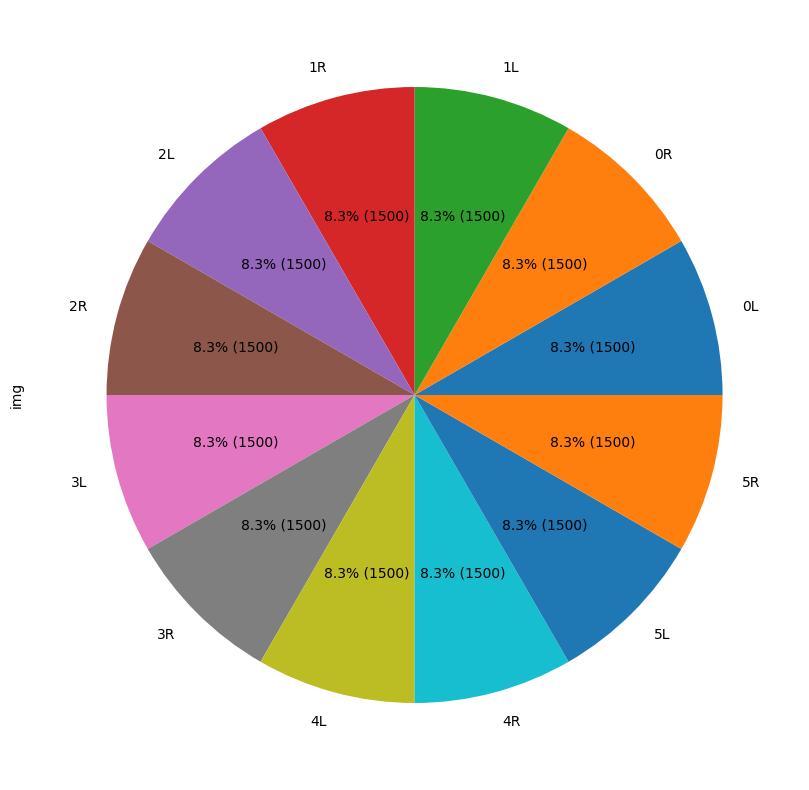

In [9]:
#group by data berdasarkan tipe member khusus pada data hari Sabtu
class_distribute_check = df_train.groupby(['label'])['img'].count()
#fungsi untuk nilai value pada pie chart dimana hasilnya persen (nilai total)
def func(pct):
  return "{:1.1f}% ({})".format(pct, round(class_distribute_check.sum() * pct / 100))
#memunculkan pie untuk data total order per tipe member
class_distribute_check.plot.pie(y='ride_id', autopct= lambda pct: func(pct), figsize = (10,10))

Dari distribusi data train, ada **12** kelas yang berbeda dimana setiap kelasnya memiliki jumlah data image yang sama yaitu **1500** data di setiap kelasnya

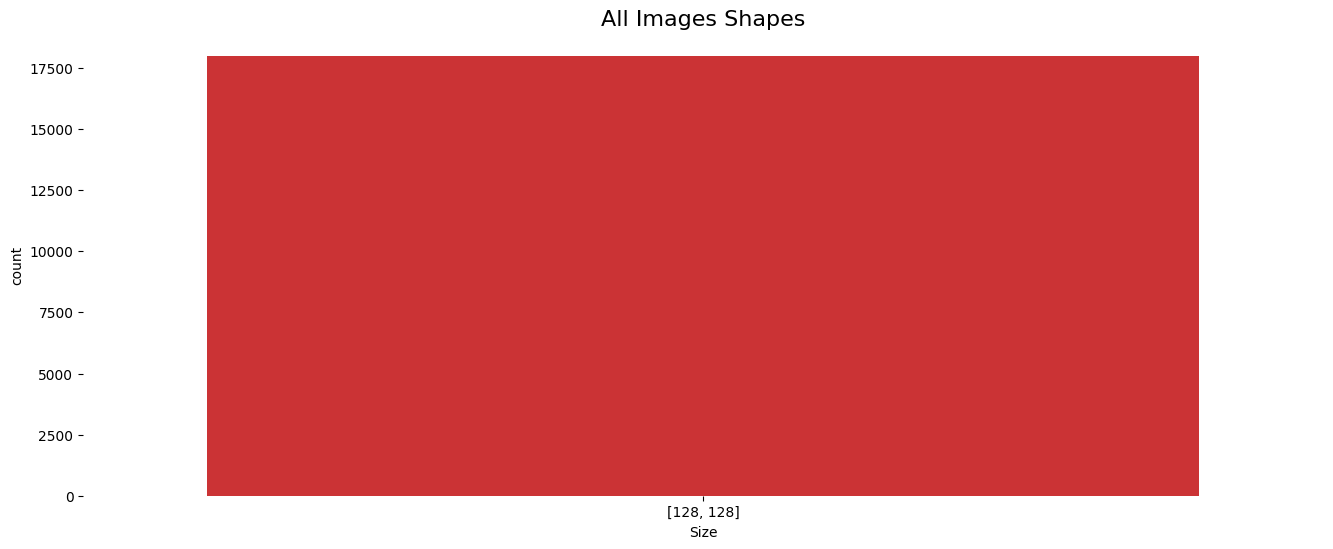

In [10]:
shapes_train = []

for k, path in enumerate(df_train['img']):
    image = plt.imread(path)
    shapes_train.append(image.shape)

shapes_train = pd.DataFrame(data = shapes_train, columns = ['H', 'W'], dtype='object')
shapes_train['Size'] = '[' + shapes_train['H'].astype(str) + ', ' + shapes_train['W'].astype(str) + ']'
plt.figure(figsize = (16, 6))

a = sns.countplot(x='Size', palette='Set1', data=shapes_train)
    
plt.title('All Images Shapes', fontsize=16)
sns.despine(left=True, bottom=True)

Seluruh size image dalam dataset ini sudah seragam dimana size image pada dataset ini adalah **128 x 128 pixel**

In [11]:
df_test.head()

,img,label
0,fingers\test\000e7aa6-100b-4c6b-9ff0-e7a8e53e4...,5L
1,fingers\test\001f6021-8581-4ed2-aed4-cda0af1d5...,5L
2,fingers\test\0027029b-4c3c-4785-bc1b-b8141331a...,3R
3,fingers\test\004599fb-c735-4ff3-a969-342dda319...,5L
4,fingers\test\00500e1a-f4bd-4f66-9eb8-c7fce19a3...,5L


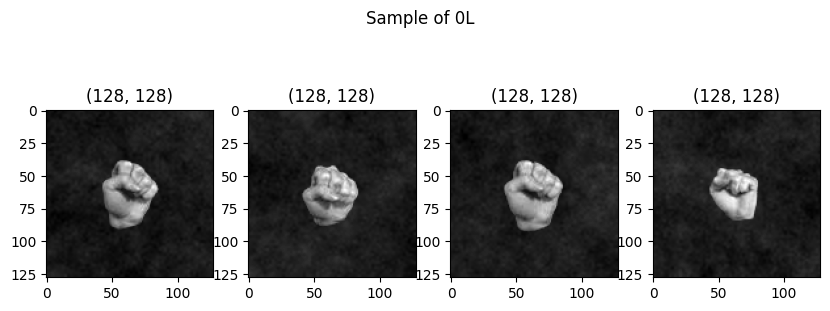

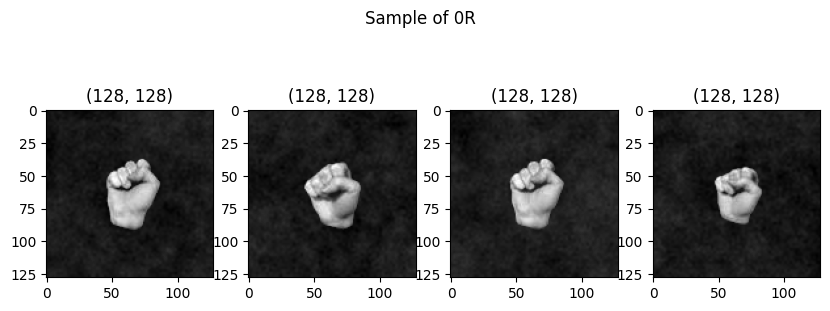

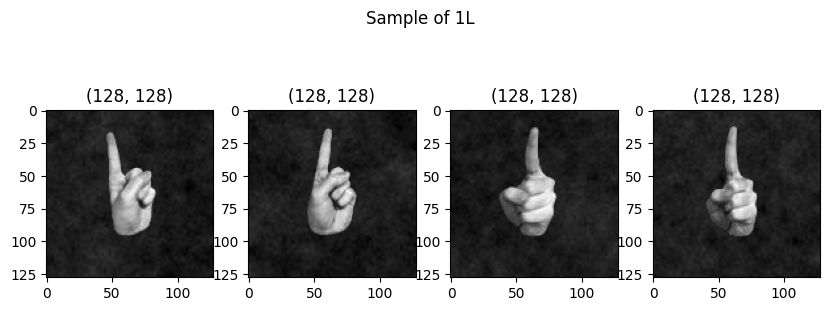

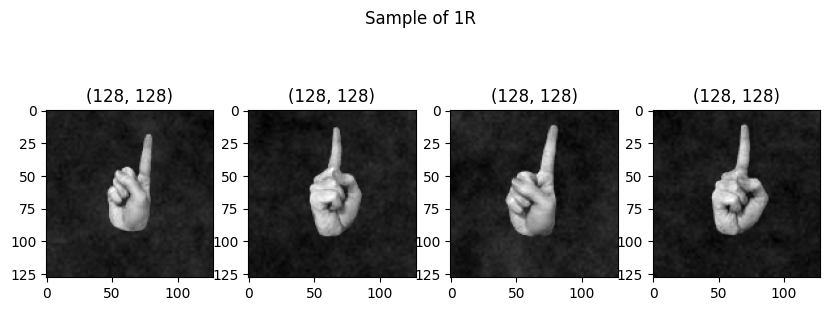

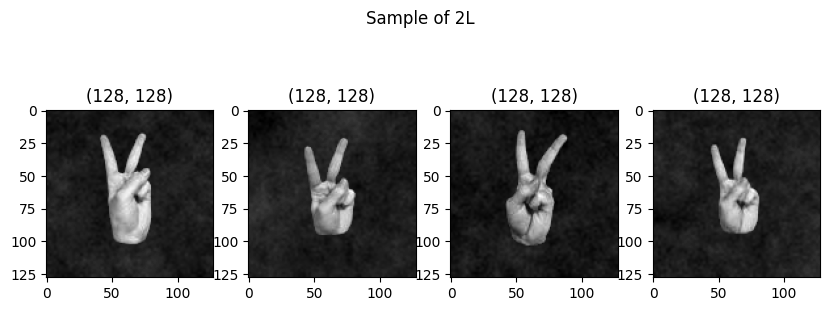

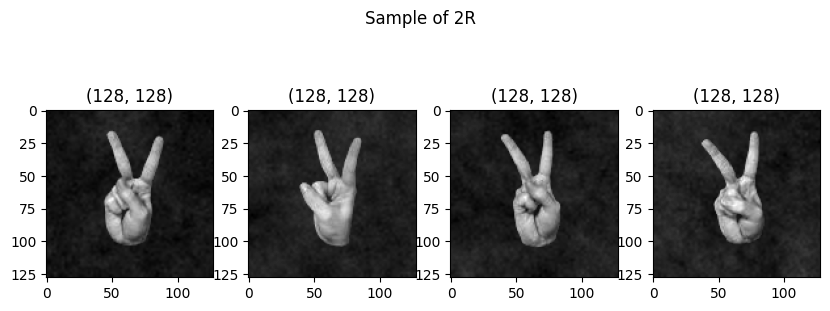

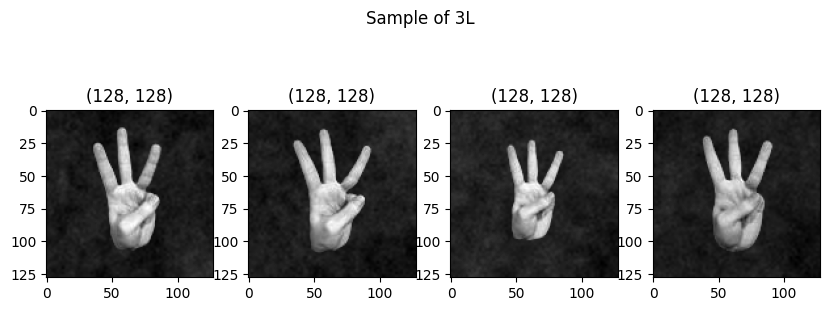

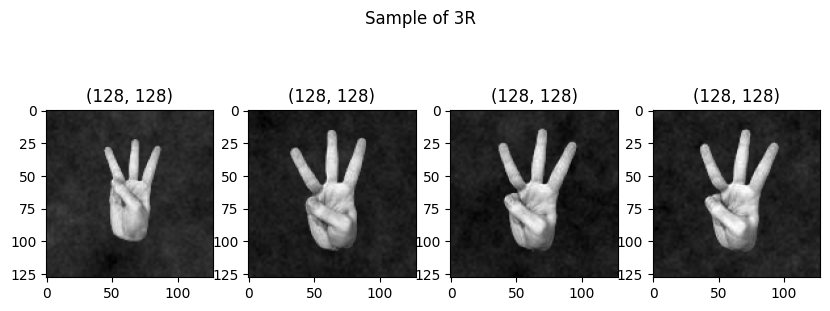

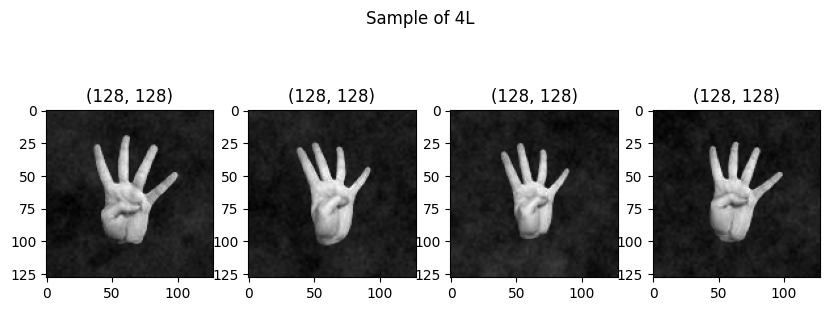

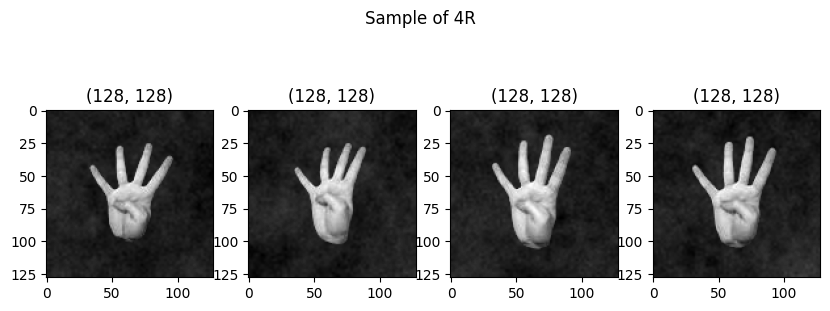

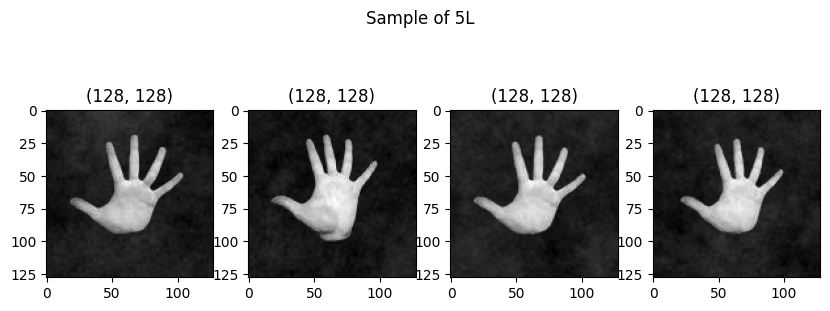

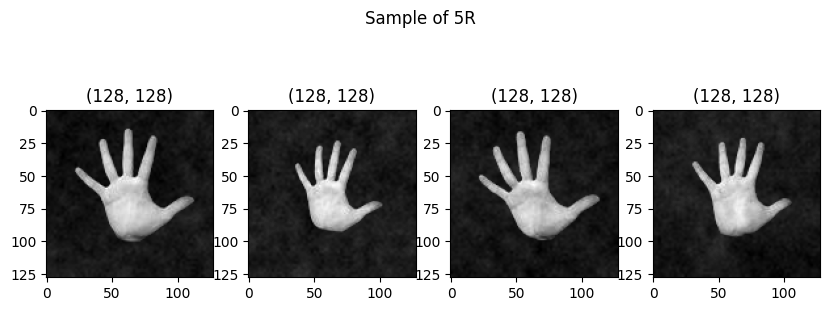

In [12]:
label_unique = df_train['label'].unique()
label_unique.sort()
for i in label_unique:
    samples = 1
    plt.figure(figsize=(10,10))
    for j in range(0,4):
        plt.suptitle(f'Sample of {i}')
        plt.subplot(4,4,samples)
        a = df_train[df_train['label'] == i]['img'].sample(ignore_index=True)[0]
        a = plt.imread(a)
        plt.imshow(a, cmap='gray')
        plt.title(f'{a.shape}')
        samples += 1
    plt.show()

Dari hasil visualisasi sample diatas, semua data image memiliki quality yang seragam. Yang membedakan dari setiap kelasnya adalah objek dari jari jari tangannya.

# Data Preprocessing

Pada dataset kasus ini, image sudah memiliki size yang seragam yaitu **128 x 128** sehingga tidak perlu melakukan resizing lagi. Selain itu karena data sudah memiliki data yang cukup banyak di setiap kelasnya yaitu **1500** data di setiap kelas, maka data tidak perlu dilakukan augmentasi lagi. Oleh karena itu pada bagian ini perlu melakukan split saja dari data train menjadi data train dan validation. Lalu untuk melakukan standarisasi data, akan dilakukan pada pembuatan model setelah data di input kedalam model (Rescale image dan normalization)

In [13]:
# Split data train
X = df_train['img']
y = df_train['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

print('Train Size : ', X_train.shape)
print('Val Size : ', X_val.shape)

Train Size :  (14400,)
Val Size :  (3600,)


In [14]:
#Fungsi untuk mendapatkan data image
def feature_data_split(path):
    feature_set = []
    for p in path:
        image = cv2.imread(p)
        feature_set.append(image)
    return feature_set

In [15]:
#read image
X_train = feature_data_split(X_train)
X_val = feature_data_split(X_val)

#convert list to array to facillitate model
X_train = np.array(X_train)
X_val = np.array(X_val)

#check shape
print('Train Size : ', X_train.shape)
print('Val Size : ', X_val.shape)

Train Size :  (14400, 128, 128, 3)
Val Size :  (3600, 128, 128, 3)


In [16]:
# Split data test
X_test = df_test['img']
y_test = df_test['label']

#read image
X_test = feature_data_split(X_test)

#convert list to array to facilitate model
X_test = np.array(X_test)

In [17]:
#Encode label
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [18]:
# Mengambil jumlah class
num_classes = len(np.unique(y_train))

# Mengubah class ke bentuk one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val,num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Melakukan check shape di data y
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(14400, 12)
(3600, 12)
(3600, 12)


# Model

In [19]:
# Untuk menyimpan hasil evaluasi model
all_report = {}

## Baseline Model

### Model Definition

In [20]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [21]:
model_baseline = Sequential()
model_baseline.add(Rescaling(1./255,
                           input_shape=(X_train[0].shape))) # Rescaling
model_baseline.add(Conv2D(32, 4,
                           activation='relu',
                           padding='same')) # Convolation Layer 1
model_baseline.add(MaxPooling2D()) # Max Pooling 1
model_baseline.add(Conv2D(16, 4,
                           activation='relu',
                           padding='same')) # Convolation Layer 2
model_baseline.add(MaxPooling2D()) # Max Pooling 2
model_baseline.add(Conv2D(8, 4,
                           activation='relu',
                           padding='same')) # Convolation Layer 3
model_baseline.add(MaxPooling2D()) # Max Pooling 3
model_baseline.add(Flatten())
model_baseline.add(Dense(128, activation='relu'))
model_baseline.add(Dense(units=12, activation='softmax'))

# Compile
model_baseline.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy', 'Recall'])
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        8208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         2

#### Model Training

In [22]:
# Train the Model

history_seq = model_baseline.fit(x = X_train, y = y_train,
                                   epochs=50,
                                   validation_data=(X_val,y_val),
                                   batch_size=16,
                                   callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/50
900/900 [==============================] - 26s 19ms/step - loss: 0.1431 - accuracy: 0.9535 - recall: 0.9396 - val_loss: 7.2576e-04 - val_accuracy: 0.9994 - val_recall: 0.9994
Epoch 2/50
900/900 [==============================] - 16s 18ms/step - loss: 1.4240e-04 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 5.4943e-05 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 3/50
900/900 [==============================] - 16s 18ms/step - loss: 1.2810e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 4.9022e-05 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 4/50
900/900 [==============================] - 17s 19ms/step - loss: 6.6563e-06 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 2.2815e-05 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 5/50
900/900 [==============================] - 18s 20ms/step - loss: 3.6293e-06 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 1.2455e-05 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 6/50
900/900 [==============================] - 

#### Model Evaluation

In [23]:
# Create DataFrame

history_seq_df = pd.DataFrame(history_seq.history)

<Axes: >

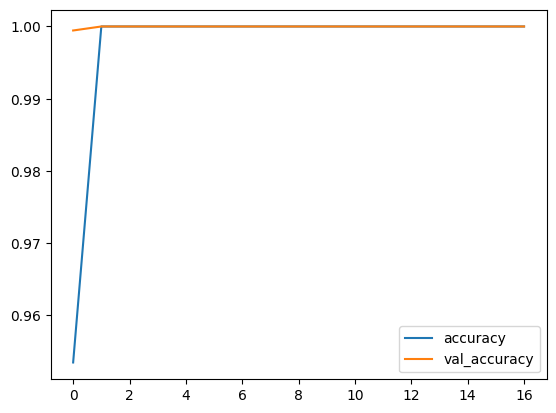

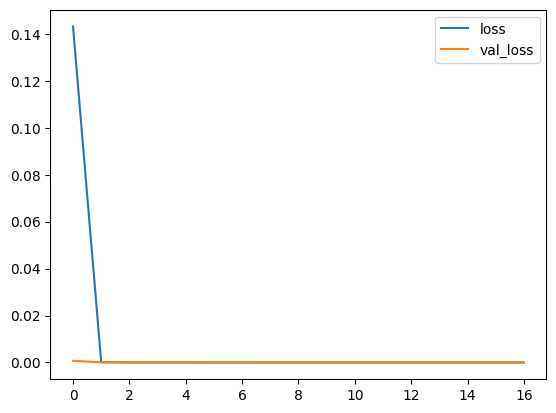

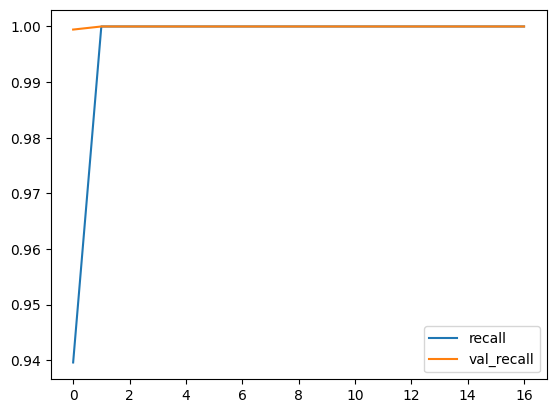

In [24]:
# Plot Training Results

history_seq_df[['accuracy', 'val_accuracy']].plot()
history_seq_df[['loss', 'val_loss']].plot()
history_seq_df[['recall', 'val_recall']].plot()

113/113 [==============================] - 1s 7ms/step
Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       300
           5       1.00      1.00      1.00       300
           6       1.00      1.00      1.00       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300
          10       1.00      1.00      1.00       300
          11       1.00      1.00      1.00       300

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600

Confusion Matrix      : 


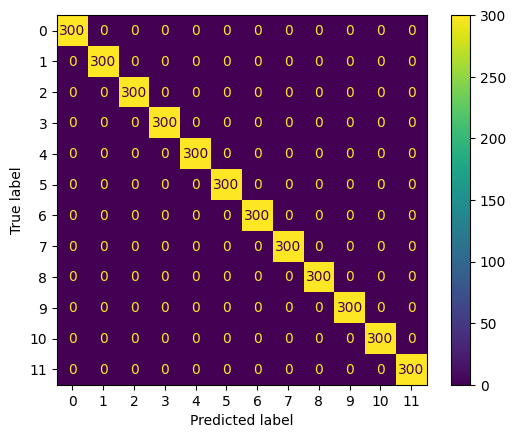

In [25]:
# Evaluate Test-Set

y_pred_func = model_baseline.predict(X_test)
y_pred_func = np.argmax(y_pred_func, axis=-1)

print('Classification report : \n',classification_report(np.argmax(y_test, axis=-1), y_pred_func))
print('Confusion Matrix      : \n', ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test, axis=-1), y_pred_func)).plot())

Dari hasil analisa model diatas, model sudah goodfit dalam metric loss dan accuracy. Namun dalam melakukan trainingnya model menghabiskan waktu 16-26 detik per epochnya. Oleh karena itu, model akan dilakukan improvement dari sisi speednya yang dimana target dalam improvement adalah speed yang lebih cepat namun tidak menurunkan akurasi ataupun recall dari model. Untuk itu improvement akan dilakukan dengan pengurangan layer dan neuron pada model

### Model Improvement

#### Model Definition

In [26]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [27]:
model_improved = Sequential()
model_improved.add(Rescaling(1./255,
                           input_shape=(X_train[0].shape))) # Rescaling
model_improved.add(Conv2D(16, 4,
                           activation='relu',
                           padding='same')) # Convolation Layer 2
model_improved.add(MaxPooling2D()) # Max Pooling 2
model_improved.add(Conv2D(8, 4,
                           activation='relu',
                           padding='same')) # Convolation Layer 3
model_improved.add(MaxPooling2D()) # Max Pooling 3
model_improved.add(Flatten())
model_improved.add(Dense(128, activation='relu'))
model_improved.add(Dense(units=12, activation='softmax'))

# Compile
model_improved.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy', 'Recall'])
model_improved.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         2056      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0

#### Model Training

In [28]:
# Train the Model

history_seq = model_improved.fit(x = X_train, y = y_train,
                                   epochs=50,
                                   validation_data=(X_val,y_val),
                                   batch_size=16,
                                   callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/50
900/900 [==============================] - 11s 12ms/step - loss: 0.1056 - accuracy: 0.9688 - recall: 0.9542 - val_loss: 0.0016 - val_accuracy: 0.9997 - val_recall: 0.9997
Epoch 2/50
900/900 [==============================] - 9s 10ms/step - loss: 0.0081 - accuracy: 0.9976 - recall: 0.9972 - val_loss: 5.3962e-05 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 3/50
900/900 [==============================] - 9s 10ms/step - loss: 2.6266e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 2.2686e-05 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 4/50
900/900 [==============================] - 9s 10ms/step - loss: 1.1504e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 1.1738e-05 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 5/50
900/900 [==============================] - 9s 10ms/step - loss: 5.9810e-06 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 7.4543e-06 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 6/50
900/900 [==============================] - 9s 10ms/step

#### Model Evaluation

In [29]:
# Create DataFrame

history_seq_df = pd.DataFrame(history_seq.history)

<Axes: >

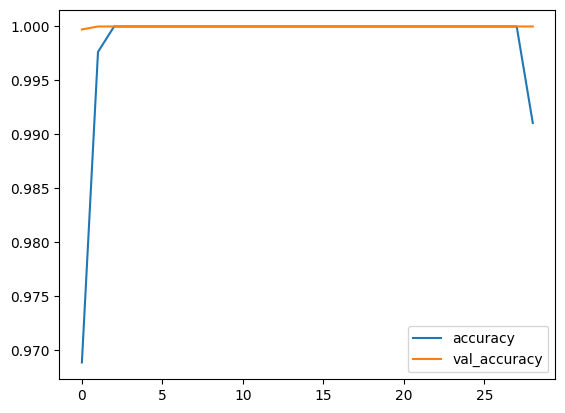

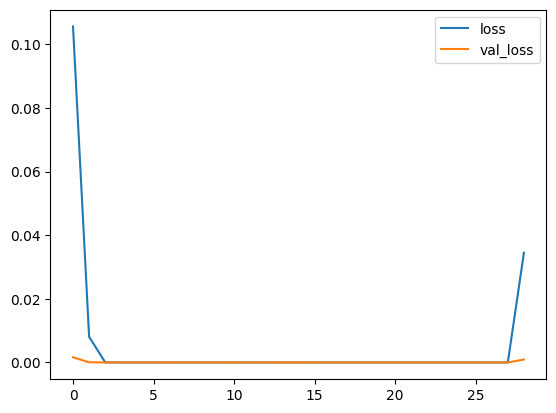

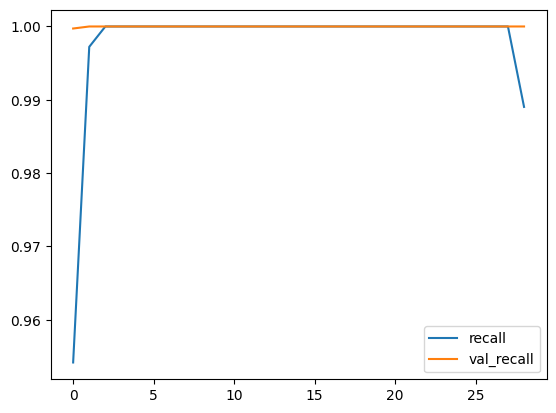

In [30]:
# Plot Training Results

history_seq_df[['accuracy', 'val_accuracy']].plot()
history_seq_df[['loss', 'val_loss']].plot()
history_seq_df[['recall', 'val_recall']].plot()

113/113 [==============================] - 1s 5ms/step
Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00       300
           5       0.99      1.00      1.00       300
           6       1.00      1.00      1.00       300
           7       1.00      0.99      1.00       300
           8       1.00      1.00      1.00       300
           9       1.00      1.00      1.00       300
          10       1.00      1.00      1.00       300
          11       1.00      1.00      1.00       300

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600

Confusion Matrix      : 


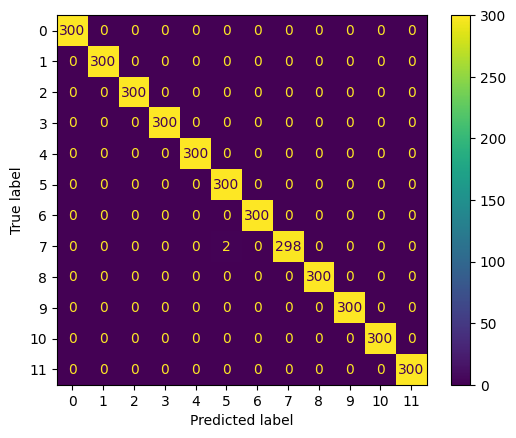

In [31]:
# Evaluate Test-Set

y_pred_func = model_improved.predict(X_test)
y_pred_func = np.argmax(y_pred_func, axis=-1)

print('Classification report : \n',classification_report(np.argmax(y_test, axis=-1), y_pred_func))
print('Confusion Matrix      : \n', ConfusionMatrixDisplay(confusion_matrix(np.argmax(y_test, axis=-1), y_pred_func)).plot())

Dari hasil analisa diatas, model masih dapat memiliki akurasi dan recall yang baik dengan kecepatan per epochnya ialah 8-12 detik per epoch. Model dapat dikatakan berhasil ditingkatkan dikarenakan model tidak mengalami penurunan dalam sisi evaluasi metric namun mengalami peningkatan dalam sisi kecepatan.

## Model Saving

In [32]:
# Freeze Model

model_improved.trainable = False
model_improved.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         2056      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0

In [33]:
# Save Preprocessor
with open('deployment/label_encoder.pkl', 'wb') as file_1:
  joblib.dump(label_encoder, file_1)
# Save CNN Model
model_improved.save('deployment/model_cnn.h5')

## Model Inference

Untuk model inference dapat di cek pada file `fingers_prediction_inference.ipynb`

# Kesimpulan

Pada kasus ini, data yang digunakan sudah cukup seragam baik dalam segi kualitas dan juga segi size (128 x 128 pixel). Sehingga hal ini mempermudah pembuatan model, dan model cenderung mendapatkan hasil yang sangat bagus. Dimana baik model baseline ataupun improvement memiliki accuracy **100%** dan recall **100%**. Dalam improvementnya, model berhasil ditingkatkan dari segi speed dan dibuat lebih sederhana tanpa menurunkan performa evaluasi model. Dimana model baseline memiliki speed 14-23 detik per epochnya sedangkan setelah di improve memiliki speed 8-12 detik per epoch.\
Walaupun begitu, hasil dari inference mengatakan hal lain. Dimana hasil - hasil dari inference lebih banyak melakukan kesalahan prediksi dibanding prediksi yang benar. Oleh karena itu untuk improvement kedepannya, lebih baik menambahkan keragaman dalam datasetnya seperti background foto dan foto tangan beserta lengannya. Karena foto dari data ini hanya menampilkan foto hitam putih dengan gambar tangannya saja, sehingga model cenderung mudah untuk mempelajari gambar tersebut dan menghasilkan hasil yang kurang baik dalam melakukan inference.\
Oleh karena itu, model perlu di latih dari data - data yang diluar dataset sekarang sehingga model dapat digunakan untuk menghitung jari dan mendeteksi tangan mana yang ditunjukkan oleh gambar